In [45]:
import json
import pandas as pd
from typing import DefaultDict, List
import numpy as np
import seaborn as sns
import logging
import sys
import matplotlib.pyplot as plt
import gzip

In [102]:
class Node:

    def __init__(self, genome_id, losses, generation):
        self.genome_id = genome_id
        self.losses = losses
        self.generation = generation
        self.children = []
        self.parents = []

    def add_child(self, child_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, self, child_node)
        self.children.append(con)

    def add_parent(self, parent_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, parent_node, self)
        self.parents.append(con)

class Edge:

    def __init__(self, name, params, parent, child):
        self.name = name
        self.params = params
        self.parent = parent
        self.child = child

class Nodes:

    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.genome_id] = node

    def has_node_id(self, node_id):
        return node_id in self.nodes.keys()

    def get_node(self, node_id):
        return self.nodes[node_id]
    
    def get_generation(self, i_generation):
        return list(filter(lambda x:x.generation==i_generation, self.nodes.values()))

    def get_all_edges(self):
        for node in self.nodes.values():
            for edge in node.children:
                yield edge

    def connect(self, nodeid_parent, nodeid_child, edge_name, edge_params):
        parent = self.get_node(nodeid_parent)
        child = self.get_node(nodeid_child)
        parent.add_child(child, edge_name, edge_params)
        child.add_parent(parent, edge_name, edge_params)

def build_graph(infile):
    generation_counter = 0
    nodes = Nodes()
    num_errors = 0
    for line in gzip.open(infile):
        try:
            data = json.loads(line)
        except Exception as e:
            num_errors += 1
            if num_errors >= 3:
                break
            logging.error(e)
            continue
        for i in range(len(data["genome_ids"])):

            losses = {key: data["losses"][key][i] for key in data["losses"].keys()}
            node = Node(
                data["genome_ids"][i], 
                losses,
                generation_counter
            )
            nodes.add_node(node)
        generation_counter += 1

        mo = data["mutations_operations"]
        if len(mo)>0:
            for i in range(len(mo["operation"])):
                father_id = mo["father_id"][i]
                child_id = mo["child_id"][i]

                if nodes.has_node_id(child_id) and nodes.has_node_id(father_id):
                    nodes.connect(
                        father_id,
                        child_id,
                        mo["operation"][i],
                        {}
                    )

        co = data["crossover_operations"]
        if len(co)>0:
            for i in range(len(co["operation"])):
                parent1 = co["parent1_genome"][i]
                parent2 = co["parent2_genome"][i]
                child_id = co["child_id"][i]
                if nodes.has_node_id(child_id) and nodes.has_node_id(parent1) and nodes.has_node_id(parent2):
                        nodes.connect(
                            parent1,
                            child_id,
                            co["operation"][i],
                            {}
                        )
                        nodes.connect(
                            parent2,
                            child_id,
                            co["operation"][i],
                            {}
                        )
    return nodes

def get_deltas(infile):
    nodes = build_graph(infile)
    deltas = []
    for edge in nodes.get_all_edges():
        for key in edge.parent.losses.keys():
            loss_delta = edge.parent.losses[key] - edge.child.losses[key]
            deltas.append([edge.name, key, np.max((0, loss_delta)), edge.child.losses[key], edge.child.generation])
    deltas = pd.DataFrame(deltas, columns=["operation", "loss_type", "delta", "loss_value", "generation"])
    return deltas

def get_success_probs(deltas):
    success_probs = []
    for loss in deltas.loss_type.unique():
        for operation in deltas.operation.unique():
            a = len(deltas.query("operation==@operation and loss_type==@loss and delta>0"))    
            b = len(deltas.query("operation==@operation and loss_type==@loss"))
            operation_str = operation
            operation_str = operation_str.replace("Mutation", "\nMutation")
            operation_str = operation_str.replace("Crossover", "\nCrossover")
            success_probs.append([operation_str, loss, a/b])

        a = len(deltas.query("delta>0"))    
        b = len(deltas)
        success_probs.append(["Total\nAverage", loss, a/b])

    success_probs = pd.DataFrame(success_probs, columns=["operation", "loss_type", "success_prob"])
    success_probs = success_probs.sort_values("success_prob", ascending=False)
    return success_probs

infile = '../../../saved_evolutions/2024-04-20T11-50-54_evolve_tamaki3/evolution_operations.jsonl.gz'
nodes = build_graph(infile)
#deltas = get_deltas(infile)
#success_probs = get_success_probs(deltas)
#sns.barplot(data=success_probs, x="operation", y="success_prob", hue="loss_type")


In [104]:
for node in nodes.nodes.values():
    print(node.losses)
    break

{'fundamental_loss': 18.05461262107375, 'tuning_loss': 1.0042159281674057, 'imp_loss': 1.577138980764344, 'wobble_freq_loss': 5.602694710312406, 'wobble_vol_loss': 3.554760102786474, 'total': 29.79342234310438}


<AxesSubplot: xlabel='operation', ylabel='success_prob'>

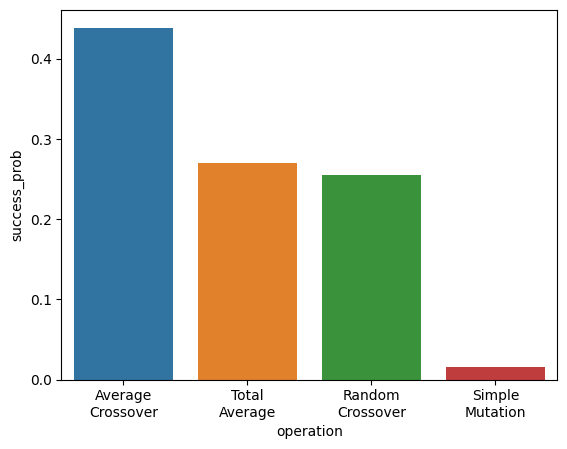

In [45]:
sns.barplot(data=success_probs.query("loss_type=='total'"), x="operation", y="success_prob")

<AxesSubplot: xlabel='bin', ylabel='success_prob'>

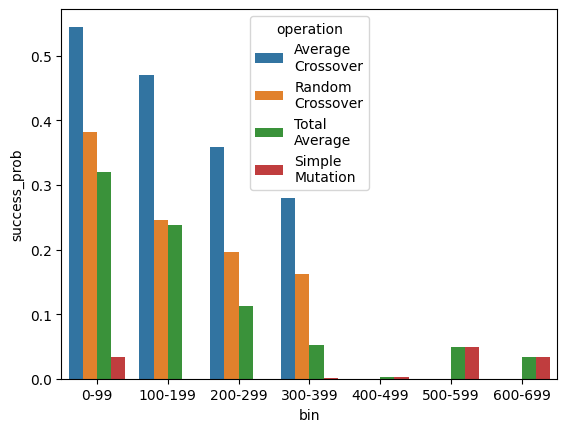

In [46]:
deltas["bin"] = np.round(deltas.generation / 100)*100
df = []
for bin in deltas.bin.unique():
    success_probs = get_success_probs(deltas.query("bin==@bin and loss_type=='total'"))
    success_probs["bin"] = f"{int(bin)}-{int(bin)+99}"
    df.append(success_probs)
df = pd.concat(df)

sns.barplot(data=df, x="bin", y="success_prob", hue="operation")


ValueError: Could not interpret input 'bin'

In [9]:
deltas.query("generation==1").sort_values(by="loss_value", ascending=False)

,operation,loss_type,delta,loss_value,generation
7237,RandomMutation,total,0.0,4.000045e+06,1
4822,RandomMutation,total,0.0,4.000031e+06,1
3674,RandomCrossover,total,0.0,4.000020e+06,1
11283,RandomCrossover,total,0.0,4.000020e+06,1
4821,RandomMutation,octave_loss,0.0,4.000000e+06,1
...,...,...,...,...,...
11419,RandomMutation,n_note_loss,5.0,0.000000e+00,1
5378,RandomCrossover,n_note_loss,0.0,0.000000e+00,1
11440,SimpleMutation,n_note_loss,0.0,0.000000e+00,1
11447,RandomCrossover,n_note_loss,0.0,0.000000e+00,1


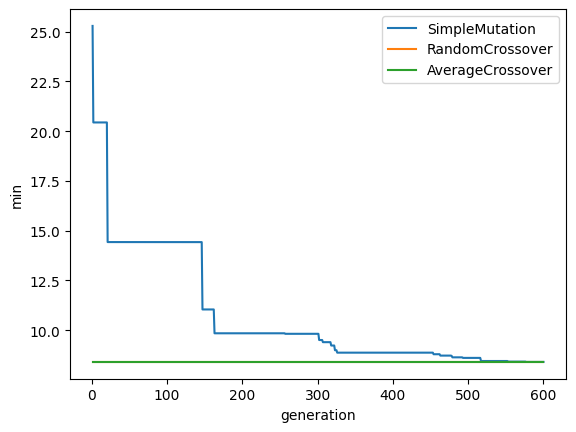

In [66]:
def loss_per_generation(deltas):

    losses = deltas.query("loss_type=='total'").sort_values("generation")
    
    _minloss = 100000000
    _avgloss = 100000000
    _maxloss = 100000000

    for operation in deltas.operation.unique():
        aggregation = []
        for generation in losses.generation.unique():
            df = losses.query("generation<=@generation and operation==@operation").sort_values("loss_value")[0:20]
            minloss = df.loss_value.min()
            avgloss = df.loss_value.mean()
            maxloss = df.loss_value.max()

            _minloss = min(_minloss, minloss)
            _avgloss = min(_avgloss, avgloss)
            _maxloss = min(_maxloss, maxloss)

            aggregation.append([generation, _minloss, _avgloss, _maxloss])
        aggregation = pd.DataFrame(aggregation, columns=["generation", "min", "mean", "max"])
        #sns.lineplot(data=aggregation, x="generation", y="mean")
        sns.lineplot(data=aggregation, x="generation", y="min", label=operation)

loss_per_generation(deltas)
plt.legend()

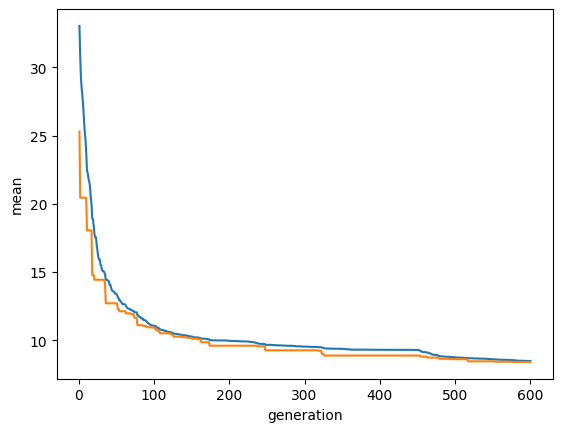

In [67]:
def loss_per_generation(deltas):

    losses = deltas.sort_values("generation")
    
    _minloss = 100000000

    for operation in deltas.operation.unique():
        aggregation = []
        for generation in losses.generation.unique():
            df = losses.query("generation<=@generation and operation==@operation").sort_values("loss_value")[0:20]
            minloss = df.loss_value.min()
            avgloss = df.loss_value.mean()
            maxloss = df.loss_value.max()

            _minloss = min(_minloss, minloss)
            _avgloss = min(_avgloss, avgloss)
            _maxloss = min(_maxloss, maxloss)

            aggregation.append([generation, _minloss, _avgloss, _maxloss])
        aggregation = pd.DataFrame(aggregation, columns=["generation", "min", "mean", "max"])
        #sns.lineplot(data=aggregation, x="generation", y="mean")
        sns.lineplot(data=aggregation, x="generation", y="min", label=operation)

loss_per_generation(deltas)
plt.legend()

In [41]:
deltas

,operation,loss_type,delta,loss_value,generation
0,RandomCrossover,tuning_loss,0.000000,9.943171,1
1,RandomCrossover,volume_loss,0.151926,0.124583,1
2,RandomCrossover,n_note_loss,0.000000,0.000000,1
3,RandomCrossover,diameter_loss,0.000597,0.044565,1
4,RandomCrossover,fundamental_loss,0.000000,5.551562,1
...,...,...,...,...,...
1312537,RandomMutation,n_note_loss,0.000000,5.000000,523
1312538,RandomMutation,diameter_loss,0.000000,0.045983,523
1312539,RandomMutation,fundamental_loss,0.000000,9.346292,523
1312540,RandomMutation,octave_loss,0.000000,1.003540,523


In [25]:
aggregation

,generation,min,mean,max
0,1,13.497812,42242.787037,4.000045e+06
1,2,11.420449,73133.157975,4.000029e+06
2,4,12.309667,10126.161523,4.000029e+06
3,9,9.287090,33451.247315,4.000031e+06
4,17,11.260663,40224.924303,4.000043e+06
...,...,...,...,...
555,542,14.091722,15715.131832,4.000027e+06
556,495,7.564650,13050.621936,4.000025e+06
557,528,15.022146,49821.737053,4.000038e+06
558,475,7.923251,13135.559907,4.000046e+06


In [15]:
deltas

,operation,loss,delta,loss,generation
0,RandomCrossover,tuning_loss,0.000000,9.943171,1
1,RandomCrossover,volume_loss,0.151926,0.124583,1
2,RandomCrossover,n_note_loss,0.000000,0.000000,1
3,RandomCrossover,diameter_loss,0.000597,0.044565,1
4,RandomCrossover,fundamental_loss,0.000000,5.551562,1
...,...,...,...,...,...
1312537,RandomMutation,n_note_loss,0.000000,5.000000,523
1312538,RandomMutation,diameter_loss,0.000000,0.045983,523
1312539,RandomMutation,fundamental_loss,0.000000,9.346292,523
1312540,RandomMutation,octave_loss,0.000000,1.003540,523


In [36]:
sys.path.append("../../")
from didgelab.analysis import get_deltas

infile = '../../../saved_evolutions/2024-04-20T11-50-54_evolve_tamaki3/evolution_operations.jsonl.gz'
deltas = get_deltas(infile)
deltas

,operation,loss_type,delta,loss_value,generation
0,SimpleMutation,fundamental_loss,0.000000,31.804613,2
1,SimpleMutation,tuning_loss,0.121274,0.882942,2
2,SimpleMutation,imp_loss,0.000000,1.781308,2
3,SimpleMutation,wobble_freq_loss,0.000000,7.318499,2
4,SimpleMutation,wobble_vol_loss,0.000000,7.253357,2
...,...,...,...,...,...
1067191,SimpleMutation,tuning_loss,0.000000,0.675191,600
1067192,SimpleMutation,imp_loss,0.000000,1.619647,600
1067193,SimpleMutation,wobble_freq_loss,0.000000,6.589332,600
1067194,SimpleMutation,wobble_vol_loss,0.000000,0.836101,600


In [37]:
deltas.query("loss_type=='total'")

,operation,loss_type,delta,loss_value,generation
5,SimpleMutation,total,0.000000,49.040718,2
11,RandomCrossover,total,0.000000,30.680557,5
17,SimpleMutation,total,0.000000,79.379156,6
23,RandomCrossover,total,2.045943,27.747479,7
29,SimpleMutation,total,1.083629,28.709793,9
...,...,...,...,...,...
1067171,SimpleMutation,total,0.000000,11.499924,600
1067177,SimpleMutation,total,0.000000,9.742412,600
1067183,SimpleMutation,total,0.000000,8.892851,600
1067189,SimpleMutation,total,0.000000,11.284999,600


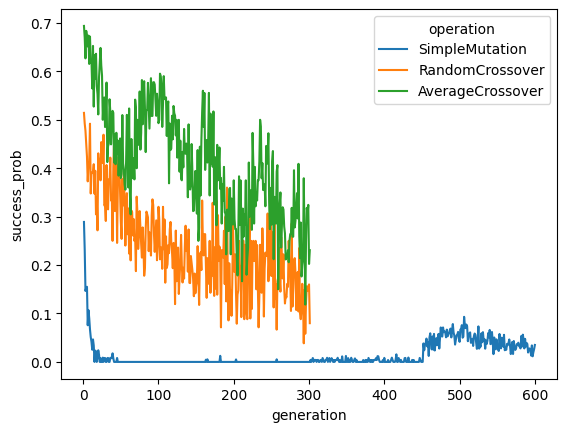

In [106]:
def success_prob_over_time(deltas):
    deltas = deltas.query("loss_type=='total'").sort_values(by="generation")

    generation = -1
    operations = deltas.operation.unique()
    
    total_operations = None
    success_operations = None
    result = []
    for ix, row in deltas.iterrows():
        if row["generation"] != generation:

            if generation>0:
                for operation in operations:
                    if total_operations[operation] > 0:
                        prob = success_operations[operation] / total_operations[operation]
                        result.append([generation, operation, prob])

            generation = row["generation"]
            total_operations = {o:0 for o in operations}
            success_operations = {o:0 for o in operations}

        total_operations[row["operation"]] += 1
        if row["delta"] > 0:
            success_operations[row["operation"]] += 1

    for operation in operations:
        if total_operations[operation] > 0:
            prob = success_operations[operation] / total_operations[operation]
            result.append([generation, operation, prob])

    result = pd.DataFrame(result, columns=["generation", "operation", "success_prob"])
    sns.lineplot(data=result, x="generation", y="success_prob", hue="operation")

sp = success_prob_over_time(deltas)

<AxesSubplot: xlabel='generation', ylabel='success_prob'>

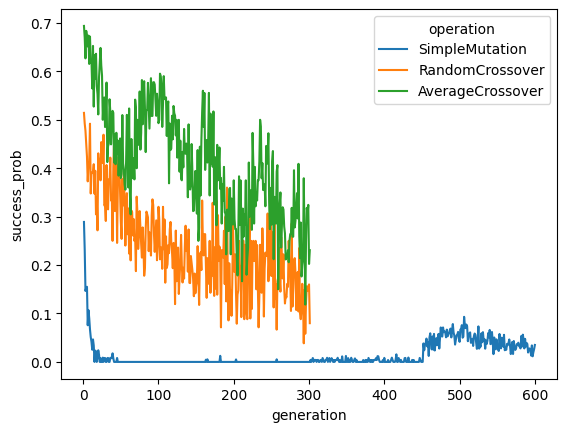

In [63]:
sns.lineplot(data=sp, x="generation", y="success_prob", hue="operation")

In [23]:
deltas

,operation,loss_type,delta,loss_value,generation
0,SimpleMutation,fundamental_loss,0.000000,31.804613,2
1,SimpleMutation,tuning_loss,0.121274,0.882942,2
2,SimpleMutation,imp_loss,0.000000,1.781308,2
3,SimpleMutation,wobble_freq_loss,0.000000,7.318499,2
4,SimpleMutation,wobble_vol_loss,0.000000,7.253357,2
...,...,...,...,...,...
1067191,SimpleMutation,tuning_loss,0.000000,0.675191,600
1067192,SimpleMutation,imp_loss,0.000000,1.619647,600
1067193,SimpleMutation,wobble_freq_loss,0.000000,6.589332,600
1067194,SimpleMutation,wobble_vol_loss,0.000000,0.836101,600


In [87]:
generations = [node.generation for node in nodes.iterate_nodes()]
generations = sorted(np.unique(generations))
losses = []
for gen in generations:
    generation = nodes.get_generation(gen)
    best_i = np.argmin([node.losses["total"] for node in generation])
    best_individual = generation[best_i].losses
    print(best_individual)
    if len(losses) == 0:
        losses.append(best_individual)
    else:
        l = {key: np.min((losses[-1][key], best_individual[key])) for key in best_individual.keys()}
        losses.append(l)   

{'total': 0.2873752788735192}
{'total': 0.25226729641539425}
{'total': 0.18078600269346992}
{'total': 0.1951816622331617}
{'total': 0.12115737496871372}
{'total': 0.08551820347079295}
{'total': 0.0}
{'total': 0.1616569279366377}
{'total': 0.12354801991599905}
{'total': 0.0579001735489943}
{'total': 0.0}
{'total': 0.1104198903057193}
{'total': 0.008465425636785645}
{'total': 0.07124245836585691}
{'total': 0.07742923810854777}
{'total': 0.0}
{'total': 0.09072505583962703}
{'total': 4.326350202203678e-05}
{'total': 0.011646958543470476}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.019433080239734852}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 4.9751966445774664e-05}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'total': 0.0}
{'to

KeyboardInterrupt: 

In [86]:
losses

[{'total': 0.2873752788735192},
 {'total': 0.25226729641539425},
 {'total': 0.18078600269346992},
 {'total': 0.18078600269346992},
 {'total': 0.12115737496871372},
 {'total': 0.08551820347079295},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'total': 0.0},
 {'t

In [41]:
deltas.query("loss_type=='total'").sort_values(by="generation")

,operation,loss_type,delta,loss_value,generation
3797,SimpleMutation,total,0.607913,48.628753,1
5777,SimpleMutation,total,8.283454,56.877634,1
5789,RandomCrossover,total,12.342371,52.934221,1
4715,RandomCrossover,total,24.391600,29.996716,1
5807,AverageCrossover,total,22.868397,42.459835,1
...,...,...,...,...,...
1047035,SimpleMutation,total,0.000000,9.286350,600
1047299,SimpleMutation,total,0.000000,10.794071,600
1047347,SimpleMutation,total,0.000000,9.879153,600
1053125,SimpleMutation,total,0.000657,8.839325,600


<AxesSubplot: xlabel='generation', ylabel='min_loss'>

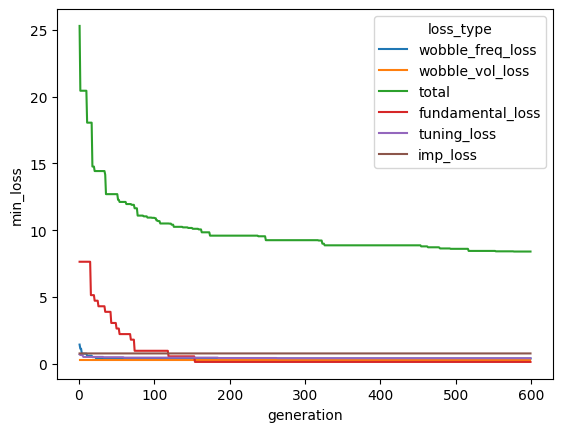

In [73]:
sns.lineplot(data=df, x="generation", y="min_loss", hue="loss_type")

In [27]:
df.query("loss_type=='total'")

,generation,loss_type,min_loss
1,1,total,7.637946
7,2,total,7.637946
13,3,total,7.637946
19,4,total,7.637946
25,5,total,7.637946
...,...,...,...
3472,595,total,7.637946
3478,596,total,7.637946
3484,597,total,7.637946
3490,598,total,7.637946


In [10]:
deltas.query("generation==1")

,operation,loss_type,delta,loss_value,generation
60,RandomCrossover,fundamental_loss,0.000000,23.471279,1
61,RandomCrossover,tuning_loss,0.173449,0.826840,1
62,RandomCrossover,imp_loss,0.031494,1.581933,1
63,RandomCrossover,wobble_freq_loss,1.250000,4.873528,1
64,RandomCrossover,wobble_vol_loss,1.552171,1.249206,1
...,...,...,...,...,...
6625,RandomCrossover,tuning_loss,0.116881,1.329772,1
6626,RandomCrossover,imp_loss,0.101418,1.652466,1
6627,RandomCrossover,wobble_freq_loss,0.000000,4.452335,1
6628,RandomCrossover,wobble_vol_loss,75.404634,7.534008,1


In [68]:
deltas.query("generation==500").operation.unique()

array(['SimpleMutation'], dtype=object)

In [ ]:
def get_success_probs(deltas):
    success_probs = []
    for loss in deltas.loss_type.unique():
        for operation in deltas.operation.unique():
            a = len(deltas.query("operation==@operation and loss_type==@loss and delta>0"))    
            b = len(deltas.query("operation==@operation and loss_type==@loss"))
            operation_str = operation
            operation_str = operation_str.replace("Mutation", "\nMutation")
            operation_str = operation_str.replace("Crossover", "\nCrossover")
            success_probs.append([operation_str, loss, a/b])

        a = len(deltas.query("delta>0"))    
        b = len(deltas)
        success_probs.append(["Total\nAverage", loss, a/b])

    success_probs = pd.DataFrame(success_probs, columns=["operation", "loss_type", "success_prob"])
    success_probs = success_probs.sort_values("success_prob", ascending=False)
    return success_probs


In [97]:

class Nodes:

    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.genome_id] = node

    def has_node_id(self, node_id):
        return node_id in self.nodes.keys()

    def get_node(self, node_id):
        return self.nodes[node_id]
    
    def get_generation(self, i_generation):
        return list(filter(lambda x:x.generation==i_generation, self.nodes.values()))

    def iterate_edges(self):
        for node in self.nodes.values():
            for edge in node.children:
                yield edge

    def connect(self, nodeid_parent, nodeid_child, edge_name, edge_params):
        parent = self.get_node(nodeid_parent)
        child = self.get_node(nodeid_child)
        parent.add_child(child, edge_name, edge_params)
        child.add_parent(parent, edge_name, edge_params)

    def iterate_nodes(self):
        return self.nodes.values()

def build_graph(infile):
    generation_counter = 0
    nodes = Nodes()
    num_errors = 0
    for line in gzip.open(infile):
        try:
            data = json.loads(line)
            print(json.dumps(data, indent=4))
            return
        except Exception as e:
            num_errors += 1
            if num_errors >= 3:
                break
            logging.error(e)
            continue
        for i in range(len(data["genome_ids"])):

            losses = {key: data["losses"][key][i] for key in data["losses"].keys()}
            node = Node(
                data["genome_ids"][i], 
                losses,
                generation_counter
            )
            nodes.add_node(node)
        generation_counter += 1

        mo = data["mutations_operations"]
        if len(mo)>0:
            for i in range(len(mo["operation"])):
                father_id = mo["father_id"][i]
                child_id = mo["child_id"][i]

                if nodes.has_node_id(child_id) and nodes.has_node_id(father_id):
                    nodes.connect(
                        father_id,
                        child_id,
                        mo["operation"][i],
                        {}
                    )

        co = data["crossover_operations"]
        if len(co)>0:
            for i in range(len(co["operation"])):
                parent1 = co["parent1_genome"][i]
                parent2 = co["parent2_genome"][i]
                child_id = co["child_id"][i]
                if nodes.has_node_id(child_id) and nodes.has_node_id(parent1) and nodes.has_node_id(parent2):
                        nodes.connect(
                            parent1,
                            child_id,
                            co["operation"][i],
                            {}
                        )
                        nodes.connect(
                            parent2,
                            child_id,
                            co["operation"][i],
                            {}
                        )
    return nodes

infile = "../../../evolutions/2024-04-21T15-00-01_nuevolution/evolution_operations.jsonl.gz"
nodes = build_graph(infile)


{
    "genome_ids": [
        180,
        32,
        157,
        85,
        60,
        152,
        16,
        47,
        123,
        118,
        74,
        77,
        38,
        90,
        126,
        162,
        161,
        88,
        73,
        147,
        175,
        131,
        137,
        40,
        171,
        183,
        165,
        64,
        117,
        51,
        133,
        186,
        86,
        102,
        194,
        2,
        145,
        169,
        34,
        89,
        43,
        166,
        111,
        10,
        54,
        4,
        53,
        33,
        140,
        153,
        46,
        114,
        58,
        143,
        13,
        122,
        110,
        106,
        59,
        198,
        87,
        95,
        25,
        35,
        80,
        138,
        79,
        189,
        81,
        14,
        69,
        3,
        37,
        107,
        15,
        70,
        108,
        68,
        1

In [95]:
for node in nodes.iterate_nodes():
    print(node.losses)
    break

{'total': 0.2873752788735192}


In [5]:
data = []
for edge in nodes.iterate_edges():
    data.append([edge.name, edge.child.generation])
data = pd.DataFrame(data, columns=["operation", "generation"])
data.sort_values("generation")

,operation,generation
199,AverageCrossover,1
499,SimpleMutation,1
245,AverageCrossover,1
496,SimpleMutation,1
248,RandomCrossover,1
...,...,...
26670,SimpleMutation,1000
55978,SimpleMutation,1000
24261,SimpleMutation,1000
24031,SimpleMutation,1000


In [60]:
generations = {}

for node in nodes.iterate_nodes():
    if node.generation not in generations:
        generations[node.generation] = {}
    
    for loss_type, value in node.losses.items():
        if loss_type not in generations[node.generation]:
            generations[node.generation][loss_type] = []

        print(loss_type)
        
        generations[node.generation][loss_type].append(value)

indizes = sorted(generations.keys())
best_losses = None
data = []
for i in indizes:

    generation_losses = {key: np.min(value) for key, value in generations[i].items()}
    print(generation_losses)
    if best_losses is None:
        best_losses = generation_losses
    print(best_losses)

    best_losses = {key: np.argmin((generation_losses[key], best_losses[key])) for key in best_losses.keys()}
    print(best_losses)
    for key, value in best_losses.items():
        data.append([i, key, value])

    break

data = pd.DataFrame(data, columns=["generation", "loss_type", "loss"])
data

total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
total
tota

,generation,loss_type,loss
0,0,total,0


In [64]:
nodes.nodes[180].losses

{'total': 0.2873752788735192}